In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc

In [2]:
data = pd.read_csv("C:/Users/rahul/Downloads/Placement_Data_Full_Class.csv")

data.drop("sl_no", axis=1, inplace=True)

**PREDICTING WHETHER A STUDENT WILL GET PLACED OR NOT**

Encoding Data

In [4]:
data.drop(['ssc_b','hsc_b', 'salary'], axis=1, inplace=True)
data["gender"] = data.gender.map({"M":0,"F":1})

data["workex"] = data.workex.map({"No":0, "Yes":1})
data["specialisation"] = data.specialisation.map({"Mkt&HR":0, "Mkt&Fin":1})
for column in ['hsc_s', 'degree_t']:
    dummies = pd.get_dummies(data[column])
    data[dummies.columns] = dummies
data.drop(['degree_t','hsc_s'], axis=1, inplace=True)
data.head()

,gender,ssc_p,hsc_p,degree_p,workex,etest_p,specialisation,mba_p,status,Arts,Commerce,Science,Comm&Mgmt,Others,Sci&Tech
0,0,67.00,91.00,58.00,0,55.0,0,58.80,Placed,0,1,0,0,0,1
1,0,79.33,78.33,77.48,1,86.5,1,66.28,Placed,0,0,1,0,0,1
2,0,65.00,68.00,64.00,0,75.0,1,57.80,Placed,1,0,0,1,0,0
3,0,56.00,52.00,52.00,0,66.0,0,59.43,Not Placed,0,0,1,0,0,1
4,0,85.80,73.60,73.30,0,96.8,1,55.50,Placed,0,1,0,1,0,0


In [5]:
data["status"] = data.status.map({"Not Placed":0,"Placed":1})

In [6]:
data.drop(['Others', 'Arts'], axis=1, inplace=True)

In [8]:
y = data['status']
data.drop('status', axis = 1, inplace = True)
sc = StandardScaler()
X = sc.fit_transform(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [9]:
print("X-Train:",X_train.shape)
print("X-Test:",X_test.shape)
print("Y-Train:",y_train.shape)
print("Y-Test:",y_test.shape)

X-Train: (150, 12)
X-Test: (65, 12)
Y-Train: (150,)
Y-Test: (65,)


In [10]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [11]:
y_pred=log_reg.predict(X_test)

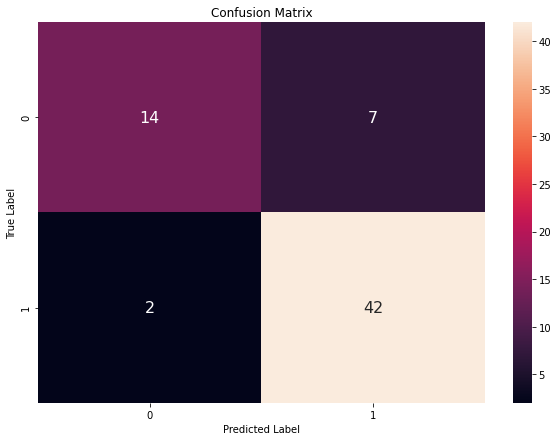

In [12]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred))
fig = plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

OBSERVATIONS:
Our confusion Matrix looks decent. We have correctly predicted 42 (placed) + 14 (not-placed) correct predictions and 7 (not placed as placed) + 2(placed as not-placed) incorrect predictions.

We need to decrease these incorrect predictions because a good candidate can be rejected (false positive)  and a unfit candidate can be selected (false negatives) 

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.67      0.76        21
           1       0.86      0.95      0.90        44

    accuracy                           0.86        65
   macro avg       0.87      0.81      0.83        65
weighted avg       0.86      0.86      0.86        65



In [14]:
accuracy = accuracy_score(y_pred, y_test)

print(f"The accuracy : {np.round(accuracy, 4)*100.0}%")

The accuracy : 86.15%


**Decision Tree Classifier**

Let's try some decision trees now and see how well they perform but as Decision trees are easy to overfit so I will use K-FOLD CV first to find the best depth.

In [15]:
depth = list(range(1,10))
cv_scores = []
for d in depth:
  dt = DecisionTreeClassifier(criterion="gini", max_depth=d, random_state=42)
  scores = cross_val_score(dt, X_train, y_train, cv=10, scoring='accuracy', n_jobs = -1)
  cv_scores.append(scores.mean())
# finding the optimal depth
optimal_depth = depth[cv_scores.index(max(cv_scores))]
print("The optimal depth value is: ", optimal_depth)

The optimal depth value is:  8


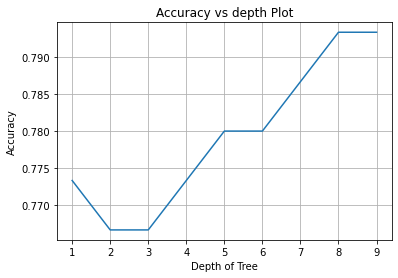

Accuracy scores for each depth value is :  [0.773 0.767 0.767 0.773 0.78  0.78  0.787 0.793 0.793]


In [16]:
# plotting accuracy vs depth
plt.plot(depth, cv_scores)
plt.xlabel("Depth of Tree")
plt.ylabel("Accuracy")
plt.title("Accuracy vs depth Plot")
plt.grid()
plt.show()

print("Accuracy scores for each depth value is : ", np.round(cv_scores, 3))

In [17]:
dt_optimal = DecisionTreeClassifier(criterion="gini", max_depth=optimal_depth, random_state=42)


dt_optimal.fit(X_train,y_train)


y_pred = dt_optimal.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)*100
print(f"The accuracy on test set using optimal depth = {optimal_depth} is {np.round(accuracy, 3)}%")

The accuracy on test set using optimal depth = 8 is 86.154%


We achieved 86% accuracy which is similiar to what we achieved using logistic regression so they seem to work equally well.

What if we could combine the power of two models to get better results? 

**Ensemble Modelling**

We will train a voting classifier using our previously trained logistic regeression and Decision tree model

In [18]:
ensembles = [log_reg, dt_optimal]


for estimator in ensembles:
    print("Training the", estimator)
    estimator.fit(X_train,y_train)

Training the LogisticRegression()
Training the DecisionTreeClassifier(max_depth=8, random_state=42)


In [19]:
scores = [estimator.score(X_test, y_test) for estimator in ensembles]

scores

[0.8615384615384616, 0.8615384615384616]

In [20]:
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ("log_reg",log_reg),
    ("dt_tree", dt_optimal),

]

In [21]:
voting_clf = VotingClassifier(named_estimators)

In [22]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('log_reg', LogisticRegression()),
                             ('dt_tree',
                              DecisionTreeClassifier(max_depth=8,
                                                     random_state=42))])

In [25]:
acc = voting_clf.score(X_test,y_test)
print(f"The accuracy on test set using voting classifier is {np.round(acc, 4)*100}%")

The accuracy on test set using voting classifier is 92.31%


We went from 86.4% to 92.3% accuracy score!

Hence, ensemble modelled voting classifier of Logistic and decision tree helped us increase the accuracy of the prediction model

**Conclusions Drawn**                                           
* More male candidates got placed as compared to female candidates.
* Male Candidates got higher CTCs as compared to female candidates.
* Type of Board choosen does not have any effect on placements thus we can drop in preprocessing steps.
* Most of the students preferred Central board in 10th grade whereas other boards in 12th grade.
* Candidates with higher percentages have better chance of placements.
* Choosing Science and Commerce as Specialisation seems to have perk when it comes to placments.
* Maximum package was bagged by male candidate from Mkt&Fin branch which is around 940k.
* Commerce is the most popular branch among candidates.
* Mean CTC is around 220k for male and female candidates individually.
* Choosing Sci&Tech and Comm&Mngmt as degree will fetch you higher CTCs.
* Mkt&Fin major have higher salaries and more placement chance as compared to Mkt&HR.
* Employability test percentage and MBA percentage does not effect the placements